In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 4.2 MB/s 
     |████████████████████████████████| 243 kB 36.9 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

Using TensorFlow version 2.7.0


## Importing the Tweet

In [3]:
dataset=nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [6]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [7]:
tweets,labels=get_tweet(train)

In [8]:
tweets[7],labels[7]

('i feel as confused about life as a teenager or as jaded as a year old man',
 'fear')

## Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences

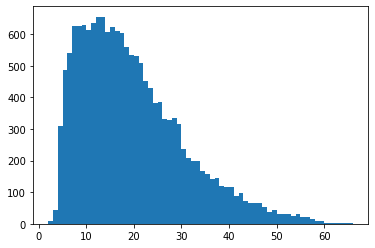

In [12]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [13]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [15]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels


In [17]:
classes=set(labels)
print(classes)

{'surprise', 'love', 'fear', 'joy', 'anger', 'sadness'}


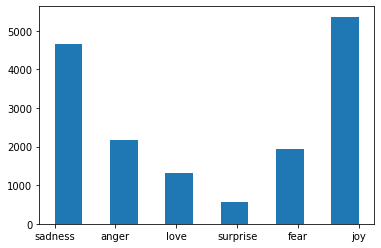

In [18]:
plt.hist(labels,bins=11)
plt.show()

In [19]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [20]:
class_to_index

{'anger': 4, 'fear': 2, 'joy': 3, 'love': 1, 'sadness': 5, 'surprise': 0}

In [21]:
index_to_class

{0: 'surprise', 1: 'love', 2: 'fear', 3: 'joy', 4: 'anger', 5: 'sadness'}

In [22]:
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels=names_to_ids(labels)
print(train_labels[0])

5


## Creating the Model


In [24]:
model=tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),  
      tf.keras.layers.Dense(6,activation='softmax')                           
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [26]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [27]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 5)

In [28]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]
)

Epoch 1/20
500/500 [==============================] - 40s 62ms/step - loss: 1.3461 - accuracy: 0.4715 - val_loss: 0.9508 - val_accuracy: 0.6525
Epoch 2/20
500/500 [==============================] - 29s 58ms/step - loss: 0.7258 - accuracy: 0.7383 - val_loss: 0.6212 - val_accuracy: 0.8035
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3556 - accuracy: 0.8884 - val_loss: 0.4497 - val_accuracy: 0.8555
Epoch 4/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2247 - accuracy: 0.9313 - val_loss: 0.4020 - val_accuracy: 0.8760
Epoch 5/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1482 - accuracy: 0.9546 - val_loss: 0.3579 - val_accuracy: 0.8860
Epoch 6/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1060 - accuracy: 0.9689 - val_loss: 0.4454 - val_accuracy: 0.8770
Epoch 7/20
500/500 [==============================] - 29s 58ms/step - loss: 0.0863 - accuracy: 0.9756 - val_loss: 0.3759 - val_accuracy:

## Evaluating the Model

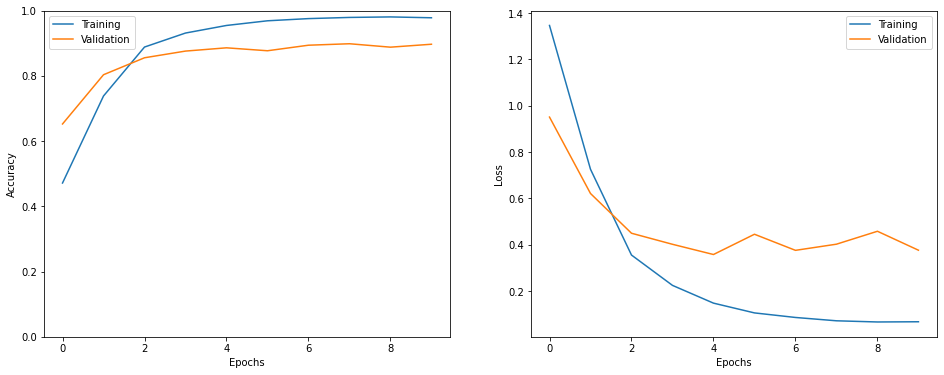

In [29]:
show_history(h)

In [30]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [31]:
_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 20ms/step - loss: 0.3936 - accuracy: 0.8895


In [32]:
i=random.randint(0,len(test_labels)-1)
print('Sentence: ',test_tweets[i])
print('Emotion: ',index_to_class[test_labels[i]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion: ',pred_class)

Sentence:  i am back to feeling determined
Emotion:  joy
Predicted Emotion:  joy


In [33]:
preds = np.argmax(model.predict(test_seq), axis=-1)

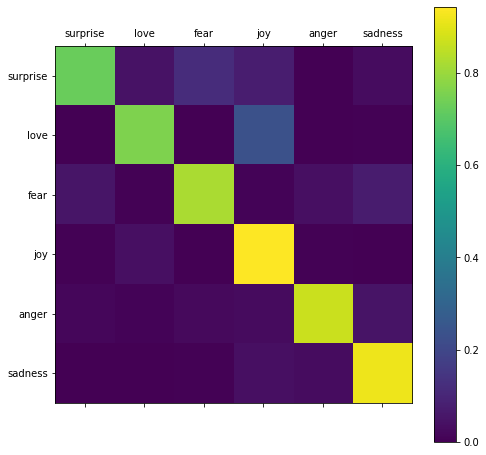

In [34]:
show_confusion_matrix(test_labels,preds,list(classes))

In [38]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,preds))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        66
           1       0.78      0.76      0.77       159
           2       0.90      0.82      0.86       224
           3       0.90      0.94      0.92       695
           4       0.88      0.87      0.88       275
           5       0.94      0.92      0.93       581

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000

